# Defining & evaluating parameterizations with pyqg

In this notebook, we'll define a new parameterization, test it, and hopefully make it clear how you can define (or learn) your own!

## Imports

Make sure latest version of pyqg is installed

In [ ]:
! mamba install --yes -c conda-forge pyqg=0.7 pyfftw

In [1]:
import fsspec
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
from pyqg.diagnostic_tools import calc_ispec

%matplotlib inline

## Defining a parameterization

Here we'll define a parameterization of the subgrid forcing of potential vorticity (learned by symbolic regression):

In [9]:
class HybridSymbolic(pyqg.QParameterization):
    def __init__(self, weights=None):
        if weights is None:
            self.weights = np.array([
                [ 1.4077349573135765e+07,  1.9300721349777748e+15,
                  2.3311494532833229e+22,  1.1828024430000000e+09,
                  1.1410567621344224e+17, -6.7029178551956909e+10,
                  8.9901990193476257e+10],
                [ 5.196460289865505e+06,  7.031351150824246e+14,
                  1.130130768679029e+11,  8.654265196250000e+08,
                  7.496556547888773e+16, -8.300923156070618e+11,
                  9.790139405295905e+11]
            ]).T[:,:,np.newaxis,np.newaxis]
        else:
            self.weights = weights

    def extract_features(self, m):
        # Define some helper functions for taking spectral differential
        # operations with as few FFTs/IFFTs as possible
        ik = m.k * 1j
        il = m.l * 1j
        real = lambda q: q if q.shape == m.q.shape else m.ifft(q)
        spec = lambda q: q if q.shape != m.q.shape else m.fft(q)
        ddx = lambda q: ik * spec(q)
        ddy = lambda q: il * spec(q)    
        laplacian = lambda q: (ik**2 + il**2) * spec(q)
        adv_real = lambda qr: ddx(m.ufull * qr) + ddy(m.vfull * qr)
        advect = lambda q: adv_real(real(q))

        # Compute basis features
        lap1_adv_q = laplacian(advect(m.q))
        lap2_adv_q = laplacian(lap1_adv_q)
        lap3_adv_q = laplacian(lap2_adv_q)
        lap2_q = laplacian(laplacian(m.q))
        lap3_q = laplacian(lap2_q)

        return np.array([
            real(feature) for feature in [ # convert them to real space
                lap1_adv_q,
                lap2_adv_q,
                lap3_adv_q,
                lap2_q,
                lap3_q,
                advect(advect(ddx(laplacian(m.v)))),
                advect(advect(ddy(laplacian(m.u)))),
            ]
        ])

    def __call__(self, m):
        return (self.weights * self.extract_features(m)).sum(axis=0)

    def __repr__(self):
        return 'HybridSymbolic'

More templates can be seen here: https://github.com/pyqg/pyqg/blob/master/pyqg/parameterizations.py

## Run baseline simulations

In [4]:
year = 24*60*60*360.
common_params = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

In [5]:
%%time
m_lowres = pyqg.QGModel(nx=64, **common_params)
m_lowres.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.57e-04, CFL: 0.044


CPU times: user 14.4 s, sys: 21.1 s, total: 35.5 s
Wall time: 11.3 s


In [6]:
%%time
m_highres = pyqg.QGModel(nx=256, **common_params)
m_highres.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 7.18e-04, CFL: 0.235


CPU times: user 3min 49s, sys: 5min 42s, total: 9min 31s
Wall time: 2min 59s


We can see that the high-resolution simulation takes much longer than the low-resolution simulation to run.

## Run the parameterized simulations

In [10]:
%%time
m_param = pyqg.QGModel(nx=64, parameterization=HybridSymbolic(),
                       **common_params)
m_param.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.67e-04, CFL: 0.054


CPU times: user 1min 10s, sys: 1min 13s, total: 2min 23s
Wall time: 56.3 s


The parameterized low-res simulation is in between.

## Plot some metrics

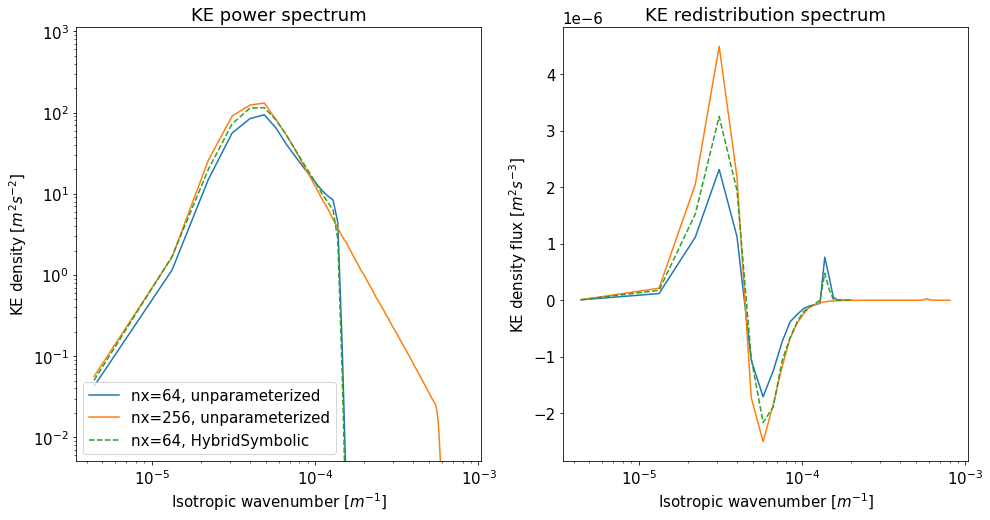

In [11]:
def plot_kwargs_for(m):
    return dict(
        label=f"nx={m.nx}, {m.parameterization or 'unparameterized'}",
        ls=('--' if m.parameterization else '-')
    )

with matplotlib.rc_context({'font.size': 15}):
    plt.figure(figsize=(16,8))

    plt.subplot(121, title="KE power spectrum")
    for m in [m_lowres, m_highres, m_param]:
        k, spec = calc_ispec(m, m.get_diagnostic('KEspec').sum(0))
        plt.loglog(k, spec, **plot_kwargs_for(m))
    plt.legend()
    plt.xlabel("Isotropic wavenumber [$m^{-1}$]")
    plt.ylabel("KE density [$m^{2}s^{-2}$]")
    plt.ylim(spec[0]/10, spec.max()*10)

    plt.subplot(122, title="KE redistribution spectrum")
    for m in [m_lowres, m_highres, m_param]:
        k, spec = calc_ispec(m, m.get_diagnostic('KEflux') +
                                m.get_diagnostic('paramspec_KEflux'))
        plt.semilogx(k, spec, **plot_kwargs_for(m))
    plt.xlabel("Isotropic wavenumber [$m^{-1}$]")
    plt.ylabel("KE density flux [$m^{2}s^{-3}$]")

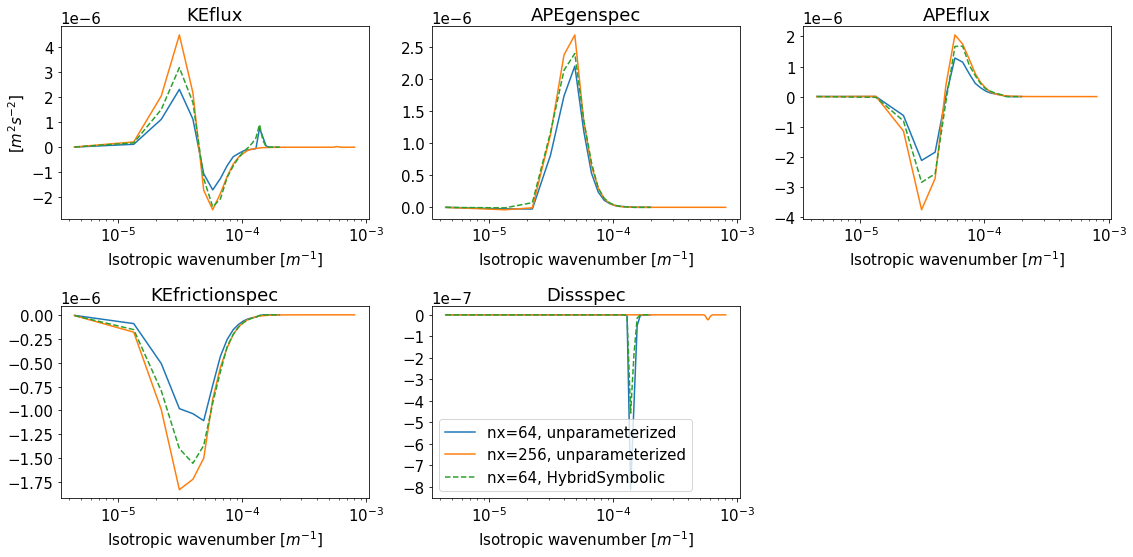

In [27]:
with matplotlib.rc_context({'font.size': 15}):
    plt.figure(figsize=(16,8))
    for i, label in enumerate(['KEflux', 'APEgenspec', 'APEflux', 'KEfrictionspec', 'Dissspec']):
        plt.subplot(2, 3, i+1, title=label)
        for j, m in enumerate([m_lowres, m_highres, m_param]):
            k, spec = calc_ispec(m, m.get_diagnostic(label))
            plt.semilogx(k, spec, **plot_kwargs_for(m))
        plt.xlabel("Isotropic wavenumber [$m^{-1}$]")
        if i == 0:
            plt.ylabel("[$m^{2}s^{-2}$]")
        if i == 4:
            plt.legend()
    plt.tight_layout()

We can quantify how much more similar the parameterized model is to the high-res model using similarity scores (max = 1, positive = closer than low-res, negative = further than low-res):

In [28]:
sim_scores = pyqg.diagnostic_tools.diagnostic_similarities(m_param, m_highres, m_lowres)
sim_scores

{'Ensspec1': 0.5577845308202023,
 'Ensspec2': 0.5196295449658188,
 'KEspec1': 0.6011464529535312,
 'KEspec2': 0.589850280630056,
 'EKEdiss': 0.6976122716934597,
 'KEfrictionspec': 0.5898502806300556,
 'EKE1': 0.6174155381441186,
 'EKE2': 0.6976122716934561,
 'Dissspec': 0.4620947885196903,
 'ENSDissspec': 0.46577330804697925,
 'entspec': 0.4260061056650336,
 'ENSflux': -0.16082658360869373,
 'ENSgenspec': 0.5619343336507574,
 'ENSfrictionspec': 0.5433876820115351,
 'APEgenspec': 0.5619343336507583,
 'APEflux': 0.48273084772218966,
 'KEflux': 0.4518552740260996,
 'APEgen': 0.8306548316733002}

## Potential hackathon activity 1: Define a new parameterization from the literature, run it, and test it

Now it's your turn -- define a parameterization by subclassing `pyqg.QParameterization` or `pyqg.UVParameterization` and defining a `__call__` method (see [the docs](https://pyqg.readthedocs.io/en/latest/api.html#parameterizations) for more details). Then, see if you can get higher (or at least positive) similarity scores!

In [ ]:
# write some code

## Potential hackathon activity 2: Learn a parameterization from data

Offline, we've generated a dataset of coarsened high resolution states and associated subgrid forcing. Can you use this dataset to learn a parameterization?

In [30]:
def get_pregenerated(path, dataset_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{dataset_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

forcing_dataset = get_pregenerated("eddy/forcing1")

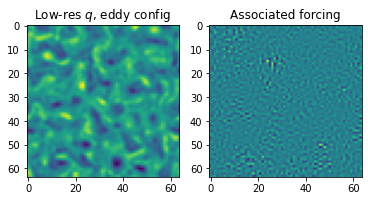

In [31]:
plt.subplot(121)
plt.imshow(forcing_dataset.q.isel(lev=0, time=-1, run=-1))
plt.title("Low-res $q$, eddy config")
plt.subplot(122)
plt.imshow(forcing_dataset.q_subgrid_forcing.isel(lev=0, time=-1, run=-1))
plt.title("Associated forcing")
plt.show()

In [32]:
# write some code!